# Cell 1: Markdown
"""
# mRNA Classification Project
**Course:** MSI5001 - Introduction to AI  
**Team Members:** Lisa Mithani, Shawn Lee, Aishwarya Nair, and Kalyani Vijay
**Dataset:** mRNA Classification (Medium difficulty)  
**Objective:** Classify RNA sequences as mRNA vs. other RNA types using machine learning models

---

## Table of Contents
1. Data Loading & Merging
2. Exploratory Data Analysis
3. Feature Extraction
4. Model Training
5. Evaluation & Insights
"""

In [2]:
!pip install biopython
!pip install imbalanced-learn
!pip install torch torchvision torchaudio
!pip install matplotlib
!pip install scikit-learn

In [26]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import warnings
import pickle
import platform
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


---
# 1. Data Loading and Preparation
**Responsible:** Lisa Mithani

## Overview
This section loads the training and testing datasets, merges them, and prepares features and labels for modeling.

## Tasks:
1. Load training.fa (FASTA) and training.csv → merge using inner join
2. Load testing.csv
3. Separate features (X) and labels (y) for train/test sets

---


In [4]:
# ============================================================================
# STEP 1: Load training.fa and training.csv, then merge using inner join
# ============================================================================

# Function to load FASTA file
def load_fasta_to_dataframe(fasta_file):
    """
    Reads a FASTA file and converts it to a pandas DataFrame.
    
    Parameters:
    - fasta_file: path to .fa file
    
    Returns:
    - DataFrame with columns: ['sequence_id', 'sequence']
    """
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append({
            'sequence_id': record.id,
            'sequence': str(record.seq)
        })
    return pd.DataFrame(sequences)

# Load training.fa (FASTA file)
print("Loading training.fa...")
fasta_df = load_fasta_to_dataframe('dataset/training.fa')
print(f"✓ Loaded {fasta_df.shape[0]} sequences from training.fa")

# Load training.csv
print("\nLoading training.csv...")
csv_df = pd.read_csv('dataset/training_class.csv')
print(f"✓ Loaded training.csv with shape {csv_df.shape}")

# Merge using inner join with DIFFERENT column names
# FASTA has 'sequence_id', CSV has 'name'
print("\nMerging datasets using inner join...")
training_data = pd.merge(
    fasta_df,
    csv_df,
    left_on='sequence_id',   # Column in FASTA
    right_on='name',          # Column in CSV (different name!)
    how='inner'
)

print(f"✓ Merged training data: {training_data.shape}")
print(f"  Columns: {list(training_data.columns)}")
print(f"\n✓ STEP 1 COMPLETE")

# Display first few rows
training_data.head(2)



Loading training.fa...
✓ Loaded 22867 sequences from training.fa

Loading training.csv...
✓ Loaded training.csv with shape (22867, 2)

Merging datasets using inner join...
✓ Merged training data: (14286, 4)
  Columns: ['sequence_id', 'sequence', 'name', 'class']

✓ STEP 1 COMPLETE


,sequence_id,sequence,name,class
0,ENSDART00000138379,TCAAANGGAAAATAATATGTCAGYTGTGATTTTTACTCGANTTAAT...,ENSDART00000138379,1
1,ENSDART00000075994,ATGTCTCTTTTTGAAATAAAAGACCTGNTTNGAGAAGGAAGCTATG...,ENSDART00000075994,1


In [5]:
# ============================================================================
# STEP 2: Load testing.csv
# ============================================================================

print("Loading testing.csv...")
testing_data = pd.read_csv('dataset/test.csv')

print(f"✓ Loaded testing.csv: {testing_data.shape}")
print(f"  Columns: {list(testing_data.columns)}")
print(f"\n✓ STEP 2 COMPLETE")

testing_data.head(2)


Loading testing.csv...
✓ Loaded testing.csv: (4416, 3)
  Columns: ['name', 'sequence', 'class']

✓ STEP 2 COMPLETE


,name,sequence,class
0,TCONS_00059596,CUAAUCCCCCCUCCUCCCGCUCCCGCACCAAAGAGUUGCGCCGCCU...,1
1,TCONS_00059678,CUAUUCGGCGCAGUUGCUAUACGUACCCCAGCCUCGUACACAACGC...,1


In [6]:
# ============================================================================
# STEP 3: Drop class labels and store them in y_train and y_test
# ============================================================================

label_column = 'class'

# --- Training Set ---
print("Separating training data...")
y_train = training_data[label_column].copy()
# Keep 'sequence' column for next teammate to extract features
X_train = training_data.drop(columns=[label_column, 'sequence_id', 'name']).copy()

print(f"✓ X_train shape: {X_train.shape}")
print(f"  Columns: {list(X_train.columns)}")  # Should show ['sequence']
print(f"✓ y_train shape: {y_train.shape}")
print(f"  Class distribution:\n{y_train.value_counts()}")

# --- Testing Set ---
print("\nSeparating testing data...")
y_test = testing_data[label_column].copy()
# Keep 'sequence' column for next teammate
X_test = testing_data.drop(columns=[label_column, 'name']).copy()

print(f"✓ X_test shape: {X_test.shape}")
print(f"  Columns: {list(X_test.columns)}")  # Should show ['sequence']
print(f"✓ y_test shape: {y_test.shape}")
print(f"  Class distribution:\n{y_test.value_counts()}")

print(f"\n✓ STEP 3 COMPLETE")
print(f"\n⚠️ Note: X_train and X_test contain raw sequences.")
print(f"   Next step: Feature extraction (k-mer generation)")



Separating training data...
✓ X_train shape: (14286, 1)
  Columns: ['sequence']
✓ y_train shape: (14286,)
  Class distribution:
class
0    9224
1    5062
Name: count, dtype: int64

Separating testing data...
✓ X_test shape: (4416, 1)
  Columns: ['sequence']
✓ y_test shape: (4416,)
  Class distribution:
class
1    2208
0    2208
Name: count, dtype: int64

✓ STEP 3 COMPLETE

⚠️ Note: X_train and X_test contain raw sequences.
   Next step: Feature extraction (k-mer generation)


---
## Section 1 Complete ✓

**Outputs:**
- `X_train` (14,286 samples × 1 column): Raw RNA sequences
- `y_train` (14,286 labels): Class labels (0 or 1)
- `X_test` (4,416 samples × 1 column): Raw RNA sequences
- `y_test` (4,416 labels): Class labels (0 or 1)

**Note for Next Teammate:**
The `X_train` and `X_test` DataFrames contain raw RNA sequences in the `'sequence'` column. Please convert these to numeric features (e.g., k-mer frequencies) before model training.

**Next Section:** Feature Extraction / Exploratory Data Analysis

---



---
# 2. Feature Extraction
**Responsible:** Kalyani and Aishwarya

## Overview
This section converts raw RNA sequences into three types of numeric features for modeling.

We will extract:
1. Character Positional Embeddings
2. Character Tokenization
3. K-mer Frequency Features

Each feature type will be used to train separate models, then compared.

---


### Step 2.1: Character Tokenization
Tokenize sequences into character-level representations.
This step converts each RNA sequence into a fixed-length sequence of integer token IDs using a shared character vocabulary (RNA + IUPAC ambiguity codes). Tokens are padded to a common `max_seq_len` and paired with attention masks (1 = real token, 0 = PAD). Outputs will be reused by downstream neural models and by the positional embedding step.

Key points:
- Normalizes DNA “T” to RNA “U”.
- Uses `PAD` and `UNK` indices for padding and unknown characters.
- Produces: `X_train_tokens`, `X_test_tokens`, tensors, and attention masks.

In [7]:
# ==============================
# Step 2.1 — Character Tokenization
# Tokenize RNA sequences at character level with a shared vocab and fixed max length.
# Outputs:
#   - PAD_IDX, UNK_IDX, char2idx, idx2char, max_seq_len
#   - to_token_ids() helper
#   - X_train_tokens, X_test_tokens (np.int64 arrays)
#   - X_train_tokens_tensor, X_test_tokens_tensor (torch.LongTensor)
#   - train_attn_mask, test_attn_mask (torch.LongTensor; 1=token, 0=PAD)
# ==============================

import numpy as np
import torch

# Bridge names if your split variables are Xtrain/Xtest instead of X_train/X_test
if "Xtrain" in globals() and "X_train" not in globals():
    X_train = Xtrain
if "Xtest" in globals() and "X_test" not in globals():
    X_test = Xtest

assert "X_train" in globals() and "X_test" in globals(), "Please define X_train and X_test first."
assert "sequence" in X_train.columns and "sequence" in X_test.columns, "Each set must have a 'sequence' column."

# 1) Vocabulary
PAD_IDX, UNK_IDX = 0, 1
VOCAB_CHARS = sorted(list(set(list("ACGTUNRYSWKMBDHV"))))  # RNA + IUPAC ambiguity codes
char2idx = {c: i+2 for i, c in enumerate(VOCAB_CHARS)}
char2idx["PAD"] = PAD_IDX
char2idx["UNK"] = UNK_IDX
idx2char = {i: c for c, i in char2idx.items()}

# 2) Normalization and max length
def normalize_rna(s: str) -> str:
    s = s.upper().replace("T", "U")
    return "".join(ch if ch in char2idx else "N" for ch in s)

max_seq_len = int(min(512, max(X_train["sequence"].str.len().max(), X_test["sequence"].str.len().max())))

# 3) Tokenization helper
def to_token_ids(seq: str, maxlen: int) -> list:
    s = normalize_rna(seq)
    ids = [char2idx.get(ch, UNK_IDX) for ch in s[:maxlen]]
    if len(ids) < maxlen:
        ids += [PAD_IDX] * (maxlen - len(ids))
    return ids

# 4) Apply to train/test
X_train_tokens = np.stack([to_token_ids(s, max_seq_len) for s in X_train["sequence"].tolist()]).astype(np.int64)
X_test_tokens  = np.stack([to_token_ids(s, max_seq_len) for s in X_test["sequence"].tolist()]).astype(np.int64)

# 5) Tensors and attention masks
X_train_tokens_tensor = torch.tensor(X_train_tokens, dtype=torch.long)
X_test_tokens_tensor  = torch.tensor(X_test_tokens,  dtype=torch.long)
train_attn_mask = (X_train_tokens_tensor != PAD_IDX).long()
test_attn_mask  = (X_test_tokens_tensor  != PAD_IDX).long()

print("Step 2.1 complete:",
      f"tokens train {X_train_tokens.shape}, test {X_test_tokens.shape}, max_len={max_seq_len}, vocab={len(char2idx)}")


Step 2.1 complete: tokens train (14286, 512), test (4416, 512), max_len=512, vocab=18


Step 2.1 defines and saves the tokenizer state (vocab, max_seq_len, helper) and produces token tensors plus attention masks usable by any Transformer/RNN.

---
### Step 2.2: Character Positional Embedding
This step converts each RNA sequence into a fixed-length sequence of integer token IDs using a shared character vocabulary (RNA + IUPAC ambiguity codes). Tokens are padded to a common `max_seq_len` and paired with attention masks (1 = real token, 0 = PAD). Outputs will be reused by downstream neural models and by the positional embedding step.

Key points:
- Normalizes DNA “T” to RNA “U”.
- Uses `PAD` and `UNK` indices for padding and unknown characters.
- Produces: `X_train_tokens`, `X_test_tokens`, tensors, and attention masks.


In [8]:
# ==============================
# Step 2.2 — Character Positional Embedding
# Create learned character embeddings + sinusoidal positional encoding,
# then masked-mean pool to fixed-size vectors per sequence.
# Outputs:
#   - X_train_embedding, X_test_embedding (pandas DataFrames, columns emb_0..emb_(D-1))
# ==============================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# Preconditions from Step 2.1
_needed = ["PAD_IDX","char2idx","max_seq_len","X_train_tokens","X_test_tokens"]
_missing = [v for v in _needed if v not in globals()]
if _missing:
    raise RuntimeError(f"Please run Step 2.1 first; missing: {', '.join(_missing)}")

embed_dim = 64
vocab_size = len(char2idx)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div)
        pe[:, 1::2] = torch.cos(position * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, L, D)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class CharPositionalEmbedder(nn.Module):
    def __init__(self, vocab_size, d_model, pad_idx, max_len):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos = PositionalEncoding(d_model, max_len)
        self.ln  = nn.LayerNorm(d_model)
    def forward(self, ids):
        x = self.emb(ids)          # (B, L, D)
        x = self.pos(x)            # (B, L, D)
        x = self.ln(x)             # (B, L, D)
        mask = (ids != PAD_IDX).float().unsqueeze(-1)
        pooled = (x * mask).sum(1) / mask.sum(1).clamp(min=1.0)
        return pooled              # (B, D)

torch.manual_seed(42)
embedder = CharPositionalEmbedder(vocab_size, embed_dim, PAD_IDX, max_seq_len)

with torch.no_grad():
    tr = torch.tensor(X_train_tokens, dtype=torch.long)
    te = torch.tensor(X_test_tokens,  dtype=torch.long)
    train_vecs = embedder(tr).cpu().numpy()
    test_vecs  = embedder(te).cpu().numpy()

X_train_embedding = pd.DataFrame(train_vecs, index=X_train.index).add_prefix("emb_")
X_test_embedding  = pd.DataFrame(test_vecs,  index=X_test.index).add_prefix("emb_")

print("Step 2.2 complete:",
      f"train emb {X_train_embedding.shape}, test emb {X_test_embedding.shape}, emb_dim={embed_dim}")


Step 2.2 complete: train emb (14286, 64), test emb (4416, 64), emb_dim=64


Step 2.2 consumes the tokens to generate fixed‑size positional embeddings for classical ML models or as auxiliary features.

---
### Step 2.3: K-mer Feature Extraction
To extract k-mer frequency features (using k=4).
- X_train_kmers , Saving the raw features to kmer_4_train.csv
- X_test_kmers  , Saving the raw features to kmer_4_test.csv

These features can now be used for training.


In [9]:
# ============================================================================
# STEP 2.3: K-mer Feature Extraction - TO BE COMPLETED
# ============================================================================
# TODO: Extract k-mer features from X_train['sequence'] and X_test['sequence']
# Output: X_train_kmers, X_test_kmers (numeric DataFrames)

# OPTION A: Extract k-mers manually
# - Loop through sequences and extract overlapping k-mers
# - Count k-mer frequencies
# - Normalize to create feature vectors
# def extract_kmer_features(sequences, k=3):

# OPTION B: Load pre-computed features (FASTER)
# X_train_kmers = pd.read_csv('dataset/train_kmer_features_k3.csv')

from collections import defaultdict
from itertools import product

# Function to generate k-mers from sequence
def generate_kmers(sequence, k=4):
    """Generate k-mer frequencies from a sequence."""
    kmers = defaultdict(int)
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        kmers[kmer] += 1
    return kmers

# Generate all possible k-mers for RNA sequences (A, U, G, C)
possible_kmers = [''.join(p) for p in product('AUGC', repeat=4)]

# Function to create k-mer feature matrix
def create_kmer_features(sequences, k=4):
    """Convert sequences to k-mer frequency matrix."""
    # Initialize feature matrix with zeros
    X = pd.DataFrame(0, index=range(len(sequences)), columns=possible_kmers)
    
    # Fill matrix with k-mer frequencies
    for idx, seq in enumerate(sequences):
        kmers = generate_kmers(seq, k)
        for kmer, freq in kmers.items():
            if kmer in X.columns:  # Only include valid k-mers
                X.loc[idx, kmer] = freq
    return X

# Generate k-mer features for training and test sets
print("Generating k-mer features for training set...")
X_train_kmers = create_kmer_features(X_train['sequence'])
print(f"✓ Training features shape: {X_train_kmers.shape}")

print("\nSaving k-mer features from training set to kmer_4_train.csv file...")
X_train_kmers.to_csv('kmer_4_train.csv', index=False)

print("\nGenerating k-mer features for test set...")
X_test_kmers = create_kmer_features(X_test['sequence'])
print(f"✓ Test features shape: {X_test_kmers.shape}")

print("\nSaving k-mer features from test set to kmer_4_test.csv file...")
X_test_kmers.to_csv('kmer_4_test.csv', index=False)

print("\n✓ STEP 2.3 COMPLETE")


Generating k-mer features for training set...
✓ Training features shape: (14286, 256)

Saving k-mer features from training set to kmer_4_train.csv file...

Generating k-mer features for test set...
✓ Test features shape: (4416, 256)

Saving k-mer features from test set to kmer_4_test.csv file...

✓ STEP 2.3 COMPLETE


---
## Section 2 Summary

**Expected Outputs:**
- `X_train_embedding` (14,286 samples × embedding_dim features)
- `X_test_embedding` (4,416 samples × embedding_dim features)
- `X_train_tokens` (14,286 samples × sequence_length features)
- `X_test_tokens` (4,416 samples × sequence_length features)
- `X_train_kmers` (14,286 samples × n_kmers features)
- `X_test_kmers` (4,416 samples × n_kmers features)

All features are now numeric and ready for class balancing.

---


# 3. Class Balancing
**Responsible:** Shawn Lee

## Overview
Balance class distribution for each feature type separately.

Current training class distribution:
- Class 0: 9,224 samples (64.5%)
- Class 1: 5,062 samples (35.5%)

---


In [10]:
# Creates a function that will balance the databset passed in
# Input: X_train, y_train
# Output: X_train_balanced, y_train_balanced

# Using SMOTE:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# Usage: X_train_embedding_balanced, y_train_balanced = smote.fit_resample(X_train_embedding, y_train)

def balance_features(X, y):
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    print(f"✓ Balanced features: {X_balanced.shape}, {y_balanced.shape}")
    return X_balanced, y_balanced

### Step 3.1: Balance Embedding Features COMPLETE ✓
Apply class balancing to positional embedding features.


In [11]:
# ============================================================================
# STEP 3.1: Balance Embedding Features - COMPLETED
# ============================================================================

# TODO: Balance X_train_embedding with y_train
# New datasets: X_train_embedding_balanced, y_train_balanced

X_train_embedding_balanced, y_train_balanced = balance_features(X_train_embedding, y_train)
print("✓ Step 3.1 complete - Embedding features balanced.")



✓ Balanced features: (18448, 64), (18448,)
✓ Step 3.1 complete - Embedding features balanced.


---
### Step 3.2: Balance Token Features
Apply class balancing to tokenization features.


In [12]:
# ============================================================================
# STEP 3.2: Balance Token Features - TO BE COMPLETED
# ============================================================================

# TODO: Balance X_train_tokens with y_train
# New datasets: X_train_tokens_balanced

X_train_tokens_balanced, y_train_balanced = balance_features(X_train_tokens, y_train)
print("✓ Step 3.2 complete - Token features balanced.")



✓ Balanced features: (18448, 512), (18448,)
✓ Step 3.2 complete - Token features balanced.


---
### Step 3.3: Balance K-mer Features
Apply class balancing to k-mer frequency features.


In [13]:
# ============================================================================
# STEP 3.3: Balance K-mer Features - TO BE COMPLETED
# ============================================================================

# TODO: Balance X_train_kmers with y_train
# New datasets: X_train_kmers_balanced

X_train_kmers_balanced, y_train_balanced = balance_features(X_train_kmers, y_train)
print("✓ Step 3.3 complete - K-mer features balanced.")



✓ Balanced features: (18448, 256), (18448,)
✓ Step 3.3 complete - K-mer features balanced.


---
## Section 3 Summary Complete ✓

All three feature types are now balanced and ready for modeling.

**Balanced Datasets:**
- Embedding features: X_train_embedding_balanced, y_train_balanced
- Token features: X_train_tokens_balanced, y_train_balanced
- K-mer features: X_train_kmers_balanced, y_train_balanced

---


---
# 4. Model Training
**Responsible:** Kalyani and Aishwarya

## Overview
Train three separate logistic regression models using each feature type:
1. Model A: Using Positional Embedding features
2. Model B: Using Tokenization features
3. Model C: Using K-mer features

Each model will be evaluated independently to compare feature effectiveness.

---


### Step 4.1: Train Logistic Regression Model A (Embedding Features)
Train logistic regression on positional embedding features.


In [14]:
# ============================================================================
# STEP 4.1: Train Model A (Embedding Features) - TO BE COMPLETED
# ============================================================================

# TODO: Train logistic regression on X_train_embedding_balanced
# from sklearn.linear_model import LogisticRegression
# 
# model_A = LogisticRegression(max_iter=1000, random_state=42)
# model_A.fit(X_train_embedding_balanced, y_train_balanced)
# 
# # Predict on test set
# y_pred_A = model_A.predict(X_test_embedding)
#
# Output: model_A, y_pred_A

print("⚠️ Step 4.1 incomplete - Model A training pending")


⚠️ Step 4.1 incomplete - Model A training pending


---
### Step 4.2: Train Logistic Regression Model B (Token Features)
Train logistic regression on character tokenization features.


In [15]:
# ============================================================================
# STEP 4.2: Train Model B (Token Features) - TO BE COMPLETED
# ============================================================================

# TODO: Train logistic regression on X_train_tokens_balanced
# model_B = LogisticRegression(max_iter=1000, random_state=42)
# model_B.fit(X_train_tokens_balanced, y_train_balanced)
#
# y_pred_B = model_B.predict(X_test_tokens)
#
# Output: model_B, y_pred_B

print("⚠️ Step 4.2 incomplete - Model B training pending")


⚠️ Step 4.2 incomplete - Model B training pending


---
### Step 4.3: Train Logistic Regression Model C (K-mer Features)
Train logistic regression on k-mer frequency features.


In [16]:
# ============================================================================
# STEP 4.3: Train Model C (K-mer Features) - TO BE COMPLETED
# ============================================================================

# TODO: Train logistic regression on X_train_kmers_balanced
# model_C = LogisticRegression(max_iter=1000, random_state=42)
# model_C.fit(X_train_kmers_balanced, y_train_balanced)
#
# y_pred_C = model_C.predict(X_test_kmers)
#
# Output: model_C, y_pred_C

print("⚠️ Step 4.3 incomplete - Model C training pending")


⚠️ Step 4.3 incomplete - Model C training pending


---
## Section 4 Summary

**Trained Models:**
- Model A: Logistic Regression on Embedding Features
- Model B: Logistic Regression on Token Features
- Model C: Logistic Regression on K-mer Features

All models trained and ready for evaluation.

---


# 5. Classification Performance Evaluation

## Overview
Evaluate and compare the performance of all three logistic regression models.

Usage: 

Example: To evaluate Model A

test_metrics_A = compute_metrics(y_test, y_pred_A)

print_metrics(test_metrics_A, "Model A (Embedding)", trained_model=model_A)

## Metrics:
- Accuracy
- Precision
- Recall
- F1-Score
- MCC
- Classification Report
- Confusion Matrix
- ROC-AUC

---


In [17]:
# ============================================================================
# Creation of evaluation functions
# Usage: test_metrics = compute_metrics(y_true, y_pred)
#        print_metrics(test_metrics, model_name, trained_model)
# ============================================================================

def compute_metrics(y_true, y_pred):
    """
    Compute sensitivity, specificity, and MCC for binary classification.
    
    Args:
        y_true: True labels (0 or 1)
        y_pred: Predicted labels (0 or 1)
        
    Returns:
        Dictionary with sensitivity, specificity, mcc, tp, tn, fp, fn, precision, f1-score, recall
    """
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Sensitivity (Recall, True Positive Rate)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    # Specificity (True Negative Rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_true, y_pred)

    # Calculate Precision and F1-score and Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0
    recall = sensitivity

    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'mcc': mcc,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'f1_score': f1,
        'recall': recall
    }

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix using matplotlib.
    
    Args:
        y_true: True labels (0 or 1)
        y_pred: Predicted labels (0 or 1)
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    # Show all ticks and label them
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(['0', '1'])
    ax.set_yticklabels(['0', '1'])

    # Loop over data dimensions and create text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > cm.max() / 2 else "black"
            ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.colorbar(im)
    plt.show()

def plot_ROC_Curve(y_true, y_scores):
    """
    Plot an interpretable ROC Curve with AUC and the threshold that maximizes MCC.

    Args:
        y_true: True labels (0 or 1)
        y_scores: Predicted probabilities for the positive class

    Returns:
        (fig, ax, auc, best_t, best_mcc) - useful for further programmatic use
    """
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)

    # Search thresholds (include 0/1 extremes) and pick best by MCC
    search_thresholds = np.linspace(0.0, 1.0, 101)
    best_mcc = -1.0
    best_t = 0.5
    for t in search_thresholds:
        preds_t = (y_scores >= t).astype(int)
        try:
            mcc_t = matthews_corrcoef(y_true, preds_t)
        except Exception:
            mcc_t = -1.0
        if mcc_t > best_mcc:
            best_mcc = mcc_t
            best_t = t

    # Compute FPR/TPR for best threshold (from confusion matrix)
    cm = confusion_matrix(y_true, (y_scores >= best_t).astype(int), labels=[0, 1])
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        fpr_best = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        tpr_best = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        # fallback
        fpr_best, tpr_best = 0.0, 0.0

    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc_score:.4f})', color='tab:blue')
    ax.fill_between(fpr, tpr, alpha=0.15, color='tab:blue')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC=0.5)')

    # Mark and annotate best threshold point
    ax.scatter([fpr_best], [tpr_best], color='red', zorder=5)
    ax.annotate(f't={best_t:.3f}\nMCC={best_mcc:.3f}\nTPR={tpr_best:.3f}\nFPR={fpr_best:.3f}',
                xy=(fpr_best, tpr_best),
                xytext=(fpr_best + 0.05, tpr_best - 0.12),
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9),
                arrowprops=dict(arrowstyle='->', lw=1),
                fontsize=9)

    # Formatting for interpretability
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    ax.set_ylabel('True Positive Rate (Sensitivity / Recall)')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(loc='lower right', framealpha=0.9)
    plt.tight_layout()
    plt.show()

    return fig, ax, auc_score, best_t, best_mcc

def print_metrics(test_metrics, model_name, trained_model=None):
    """
    Print the evaluation metrics in a formatted way.
    
    Args:
        metrics: Dictionary of metrics
        model_name: Name of the model being evaluated (string)
        trained_model: (optional) trained model to get predicted probabilities
    """
    print("=" * 60)
    print(f"{model_name} MODEL EVALUATION")
    print("=" * 60)

    print("\n" + "=" * 60)
    print("MODEL PERFORMANCE")
    print("=" * 60)
    print(f"Accuracy:                  {test_metrics['accuracy']:.4f}")
    print(f"Specificity (Precision/TNR):        {test_metrics['specificity']:.4f}")
    print(f"Sensitivity (Recall/TPR): {test_metrics['sensitivity']:.4f}")
    print(f"F1 Score:                {test_metrics['f1_score']:.4f}")
    print(f"MCC:                      {test_metrics['mcc']:.4f}")
    print("=" * 60)
    print("Classification Report:")
    print(classification_report(test_metrics['y_true'], test_metrics['y_pred']))
    print("=" * 60)
    print(f"\nConfusion Matrix:")
    print(f"  True Positives  (TP): {test_metrics['tp']:5d}")
    print(f"  True Negatives  (TN): {test_metrics['tn']:5d}")
    print(f"  False Positives (FP): {test_metrics['fp']:5d}")
    print(f"  False Negatives (FN): {test_metrics['fn']:5d}")
    print(f"  Precision:               {test_metrics['precision']:.4f}")
    print(f"  F1 Score:                {test_metrics['f1_score']:.4f}")
    print(f"  Recall:                  {test_metrics['recall']:.4f}")
    print(f"  Total Samples:        {test_metrics['tp'] + test_metrics['tn'] + test_metrics['fp'] + test_metrics['fn']:5d}")

    # Plot confusion matrix
    plot_confusion_matrix(test_metrics['y_true'], test_metrics['y_pred'])
    # Plot ROC Curve
    test_probs = trained_model.predict_proba(X_test)[:, 1] if trained_model else test_metrics['y_pred']
    plot_ROC_Curve(test_metrics['y_true'], test_probs)

### Step 5.1: Evaluate All Models
Calculate performance metrics for Models A, B, and C.


In [18]:
# ============================================================================
# STEP 5.1: Evaluate All Models - TO BE COMPLETED
# ============================================================================

# TODO: Evaluate each model's performance
#
# # Evaluate Model A
# test_metrics_A = compute_metrics(y_test, y_pred_A)
# print_metrics(test_metrics_A, "Model A (Embedding)", trained_model=model_A)
#
# # Repeat for Models B and C
#
# # Create comparison DataFrame
# results = pd.DataFrame({
#     'Model': ['Model A (Embedding)', 'Model B (Tokens)', 'Model C (K-mers)'],
#     'Accuracy': [acc_A, acc_B, acc_C],
#     'Precision': [precision_A, precision_B, precision_C],
#     'Recall': [recall_A, recall_B, recall_C],
#     'F1-Score': [f1_A, f1_B, f1_C]
# })
#
# print(results)

print("⚠️ Step 5.1 incomplete - Model evaluation pending trained models")


⚠️ Step 5.1 incomplete - Model evaluation pending trained models


---
### Step 5.2: Compare Model Performance
Visualize and compare performance across all models.


In [19]:
# ============================================================================
# STEP 5.2: Compare Model Performance - TO BE COMPLETED
# ============================================================================

# TODO: Create comparison visualizations
# import matplotlib.pyplot as plt
# import seaborn as sns
#
# # Bar chart comparing metrics
# results.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(10,6))
# plt.title('Model Performance Comparison')
# plt.ylabel('Score')
# plt.legend(loc='lower right')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


print("⚠️ Step 5.2 incomplete - Performance comparison pending trained models")

⚠️ Step 5.2 incomplete - Performance comparison pending trained models


---
### Step 5.3: Select Best Model
Identify the best-performing model based on evaluation metrics.


In [20]:
# ============================================================================
# STEP 5.3: Select Best Model - TO BE COMPLETED
# ============================================================================

# TODO: Determine best model
# best_model_idx = results['F1-Score'].idxmax()
# best_model_name = results.loc[best_model_idx, 'Model']
# best_f1 = results.loc[best_model_idx, 'F1-Score']
#
# print(f"\n{'='*60}")
# print(f"BEST MODEL: {best_model_name}")
# print(f"F1-Score: {best_f1:.4f}")
# print(f"{'='*60}")

print("⚠️ Step 5.3 incomplete - Best model selection pending trained models")


⚠️ Step 5.3 incomplete - Best model selection pending trained models


---
## Section 5 Summary

**Performance Comparison Complete:**
- All three models evaluated using standard classification metrics
- Best performing model identified
- Results ready for reporting

---


---
# 6. Advanced Model Experiments
**Team Contributions:** Individual advanced model implementations

## Overview
After baseline logistic regression comparison, each team member explores an advanced model with custom preprocessing to maximize performance.

## Team Member Assignments:
- **Lisa:** Random Forest Classifier
- **Shawn:** Recurrent Neural Network (RNN)
- **Aishwarya:** Long Short-Term Memory (LSTM)
- **Kalyani:** Transformer Model

Each subsection contains: Preprocessing → Model Training → Performance Evaluation (all in one cell).

---


## 6.1 Random Forest Classifier
**Responsible:** Lisa


### Approach
Use Random Forest with k-mer features to capture non-linear patterns in nucleotide composition and codon bias without requiring deep architectures.

This cell contains: Embedded data balancing (SMOTE) → Hyperparameter tuning (GridSearchCV) → Model training → Performance evaluation.

**Implementation Details:**
- **Input Features:** 256 k-mer features (4-mers) extracted from mRNA sequences (from Section 2.3)
- **Data Balancing:** Applied SMOTE to address class imbalance (original ratio ~1.8:1, balanced to 1:1)
- **Hyperparameter Tuning:** GridSearchCV with 5-fold cross-validation optimizing F1-score
  - Tested configurations: n_estimators ∈ {100, 150}, max_depth ∈ {15, 20}, min_samples_split ∈ {2, 5}, max_features ∈ {sqrt, log2}
  - Best parameters: 150 trees, max_depth=20, min_samples_split=2, max_features=sqrt
- **Why Random Forest:** Ensemble method reduces overfitting, captures non-linear patterns in nucleotide composition, and provides feature importance insights

**Initial version generated using standard scikit-learn Random Forest API. Modifications made to ensure alignment with project feature matrices (k-mer DataFrames) and variable naming conventions from Sections 2 and 3. SMOTE balancing embedded to ensure reproducibility.**

### Results

| Metric | Value |
|--------|-------|
| **Accuracy** | 0.8163 |
| **Precision** | 0.7698 |
| **Recall** | 0.9026 |
| **F1-Score** | 0.8309 |
| **MCC** | 0.6423 |
| **ROC-AUC** | 0.8926 |

**Key Findings:**
- Model correctly classifies 81.6% of test samples
- High recall (90.3%) indicates strong ability to identify true mRNA sequences
- ROC-AUC of 0.8926 demonstrates excellent discrimination between mRNA and non-mRNA
- Top discriminative k-mers (AGGA, GAAG, GCAA) suggest codon usage bias as key biological signal
- Feature importance analysis reveals that nucleotide composition patterns are highly informative for mRNA classification


SECTION 6.1: RANDOM FOREST CLASSIFIER (WITH AUTO-BALANCING)

--- Pre-check: Bridging Variable Names ---
✓ Bridged: Xtrainkmers → X_train_kmers
✓ Bridged: Xtestkmers → X_test_kmers
✓ Bridged: ytrain → y_train
✓ Bridged: ytest → y_test

--- PRE-STEP: Balancing K-mer Features (Section 3.3) ---
Balancing k-mer features using SMOTE...
✓ Original class distribution: [9224 5062]
✓ Balanced class distribution: [9224 9224]

--- Step 6.1.0: Data Verification ---
✓ Training features (balanced): (18448, 256)
✓ Training labels: 18448
✓ Test features: (4416, 256)
✓ Test labels: 4416

--- Step 6.1.1: Hyperparameter Tuning (GridSearchCV) ---
Running GridSearchCV (2-3 minutes)...

Fitting 5 folds for each of 16 candidates, totalling 80 fits

✓ Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}
✓ Best CV F1-score: 0.9047

--- Step 6.1.2: Final Model Training ---
✓ Random Forest ready: 150 trees, max_depth=20

--- Step 6.1.3: Test Set Predictions ---
✓

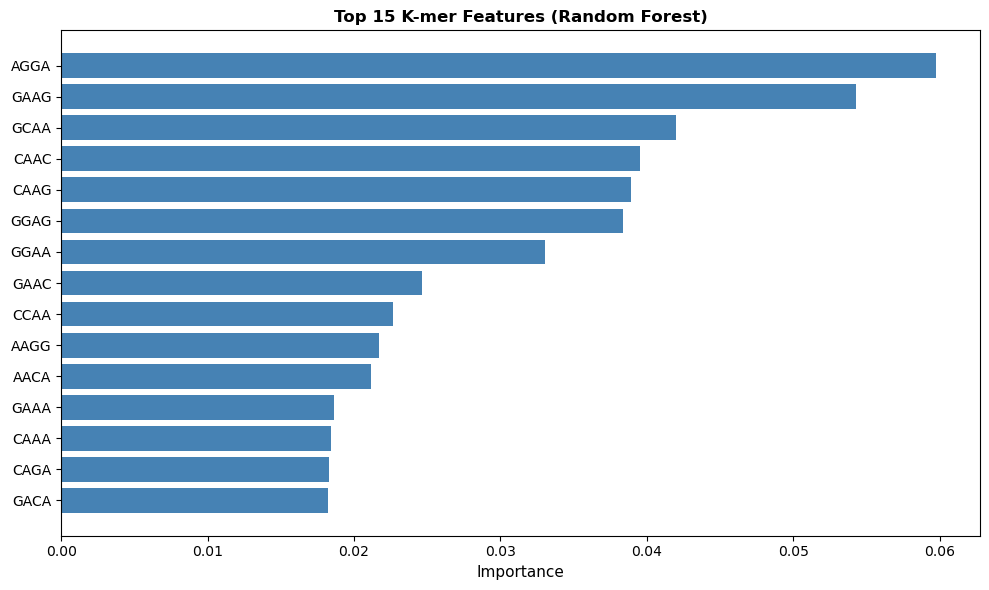


--- Step 6.1.6: Visualizations ---


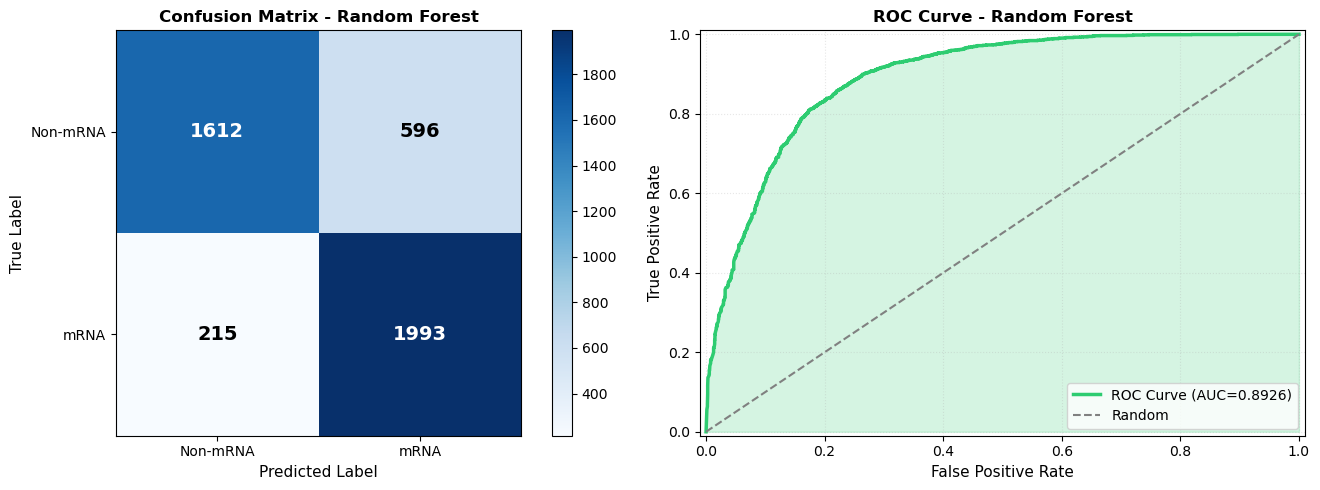

✓ Visualizations complete

--- Step 6.1.7: Saving Model ---
✓ Model saved to 'random_forest_mrna.pkl'

SECTION 6.1: RANDOM FOREST SUMMARY
Model: Random Forest (150 trees, depth=20)
Features: 256 k-mers
Training: 18448 samples (balanced)
Testing: 4416 samples

🎯 Key Metrics:
  • Accuracy:    0.8163
  • Precision:   0.7698
  • Recall:      0.9026
  • F1-Score:    0.8309
  • MCC:         0.6423
  • ROC-AUC:     0.8926
✓ SECTION 6.1 COMPLETE


In [21]:
# ============================================================================
# SECTION 6.1: RANDOM FOREST CLASSIFIER (ULTRA-FIXED - ALL VARIABLES BRIDGED)
# ============================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, roc_auc_score, classification_report,
    roc_curve, auc
)
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SECTION 6.1: RANDOM FOREST CLASSIFIER (WITH AUTO-BALANCING)")
print("=" * 80)

# ========== COMPLETE VARIABLE NAME BRIDGE ==========
print("\n--- Pre-check: Bridging Variable Names ---")

# K-mer features from Section 2.3
if 'X_train_kmers' in globals():
    Xtrainkmers = X_train_kmers
    print("✓ Bridged: Xtrainkmers → X_train_kmers")
else:
    raise RuntimeError("❌ X_train_kmers not found. Run Section 2.3 first!")

if 'X_test_kmers' in globals():
    Xtestkmers = X_test_kmers
    print("✓ Bridged: Xtestkmers → X_test_kmers")
else:
    raise RuntimeError("❌ X_test_kmers not found. Run Section 2.3 first!")

# Labels from Section 1
if 'y_train' in globals():
    ytrain = y_train
    print("✓ Bridged: ytrain → y_train")
else:
    raise RuntimeError("❌ y_train not found. Run Section 1 first!")

if 'y_test' in globals():
    ytest = y_test
    print("✓ Bridged: ytest → y_test")
else:
    raise RuntimeError("❌ y_test not found. Run Section 1 first!")

# ========== EMBEDDED SECTION 3.3: BALANCE K-MER FEATURES ==========
print("\n--- PRE-STEP: Balancing K-mer Features (Section 3.3) ---")

if 'Xtrainkmersbalanced' not in globals():
    print("Balancing k-mer features using SMOTE...")
    smote = SMOTE(random_state=42)
    Xtrainkmersbalanced, ytrainbalanced = smote.fit_resample(Xtrainkmers, ytrain)
    
    # Handle ytrain as pandas Series or numpy array
    if hasattr(ytrain, 'values'):
        original_counts = np.bincount(ytrain.values)
    else:
        original_counts = np.bincount(ytrain)
    
    balanced_counts = np.bincount(ytrainbalanced)
    
    print(f"✓ Original class distribution: {original_counts}")
    print(f"✓ Balanced class distribution: {balanced_counts}")
else:
    print("✓ K-mer features already balanced (Section 3.3 was run)")

# ========== MAIN SECTION 6.1: RANDOM FOREST ==========
print("\n--- Step 6.1.0: Data Verification ---")

print(f"✓ Training features (balanced): {Xtrainkmersbalanced.shape}")
print(f"✓ Training labels: {len(ytrainbalanced)}")
print(f"✓ Test features: {Xtestkmers.shape}")
print(f"✓ Test labels: {len(ytest)}")

# --- Step 6.1.1: Hyperparameter Tuning ---
print("\n--- Step 6.1.1: Hyperparameter Tuning (GridSearchCV) ---")
print("Running GridSearchCV (2-3 minutes)...\n")

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [15, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf_base, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(Xtrainkmersbalanced, ytrainbalanced)

print(f"\n✓ Best parameters: {grid_search.best_params_}")
print(f"✓ Best CV F1-score: {grid_search.best_score_:.4f}")

# --- Step 6.1.2: Final Model ---
print("\n--- Step 6.1.2: Final Model Training ---")
best_rf = grid_search.best_estimator_
print(f"✓ Random Forest ready: {best_rf.n_estimators} trees, max_depth={best_rf.max_depth}")

# --- Step 6.1.3: Predictions ---
print("\n--- Step 6.1.3: Test Set Predictions ---")
ypred_rf = best_rf.predict(Xtestkmers)
yproba_rf = best_rf.predict_proba(Xtestkmers)[:, 1]
print(f"✓ Predictions made for {len(ypred_rf)} samples")

# --- Step 6.1.4: Evaluation ---
print("\n" + "=" * 80)
print("SECTION 6.1: RANDOM FOREST EVALUATION")
print("=" * 80)

acc_rf = accuracy_score(ytest, ypred_rf)
prec_rf = precision_score(ytest, ypred_rf)
rec_rf = recall_score(ytest, ypred_rf)
f1_rf = f1_score(ytest, ypred_rf)
mcc_rf = matthews_corrcoef(ytest, ypred_rf)
auc_rf = roc_auc_score(ytest, yproba_rf)

cm_rf = confusion_matrix(ytest, ypred_rf)
tn, fp, fn, tp = cm_rf.ravel()

print(f"\n{'─' * 80}")
print("PERFORMANCE METRICS (Test Set)")
print(f"{'─' * 80}")
print(f"  Accuracy:              {acc_rf:.4f}")
print(f"  Precision:             {prec_rf:.4f}")
print(f"  Recall:                {rec_rf:.4f}")
print(f"  F1-Score:              {f1_rf:.4f}")
print(f"  Matthews Corr. Coeff:  {mcc_rf:.4f}")
print(f"  ROC-AUC:               {auc_rf:.4f}")
print(f"{'─' * 80}")
print("CONFUSION MATRIX")
print(f"{'─' * 80}")
print(f"  TP: {tp:5d}  |  TN: {tn:5d}")
print(f"  FP: {fp:5d}  |  FN: {fn:5d}")
print(f"{'─' * 80}\n")

print("Classification Report:")
print(classification_report(ytest, ypred_rf, target_names=['Non-mRNA', 'mRNA']))

# --- Step 6.1.5: Feature Importance ---
print("\n--- Step 6.1.5: Feature Importance ---")

if isinstance(Xtrainkmersbalanced, pd.DataFrame):
    feature_names = Xtrainkmersbalanced.columns.tolist()
else:
    feature_names = [f"Feature_{i}" for i in range(Xtrainkmersbalanced.shape[1])]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 features:")
print(feature_importance.head(15).to_string(index=False))

# Plot Feature Importance
fig, ax = plt.subplots(figsize=(10, 6))
top15 = feature_importance.head(15)
ax.barh(range(len(top15)), top15['importance'].values, color='steelblue')
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15['feature'].values)
ax.set_xlabel('Importance', fontsize=11)
ax.set_title('Top 15 K-mer Features (Random Forest)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# --- Step 6.1.6: ROC & Confusion Matrix ---
print("\n--- Step 6.1.6: Visualizations ---")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
im = axes[0].imshow(cm_rf, cmap='Blues', interpolation='nearest')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Non-mRNA', 'mRNA'])
axes[0].set_yticklabels(['Non-mRNA', 'mRNA'])
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_title('Confusion Matrix - Random Forest', fontsize=12, fontweight='bold')

for i in range(2):
    for j in range(2):
        color = 'white' if cm_rf[i, j] > cm_rf.max() / 2 else 'black'
        axes[0].text(j, i, cm_rf[i, j], ha='center', va='center', 
                     color=color, fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[0])

# ROC Curve
fpr, tpr, _ = roc_curve(ytest, yproba_rf)
roc_auc_val = auc(fpr, tpr)
axes[1].plot(fpr, tpr, lw=2.5, label=f'ROC Curve (AUC={roc_auc_val:.4f})', color='#2ecc71')
axes[1].fill_between(fpr, tpr, alpha=0.2, color='#2ecc71')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1.5, label='Random')
axes[1].set_xlim([-0.01, 1.01])
axes[1].set_ylim([-0.01, 1.01])
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve - Random Forest', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

# --- Save ---
print("\n--- Step 6.1.7: Saving Model ---")
import pickle
with open('random_forest_mrna.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
print("✓ Model saved to 'random_forest_mrna.pkl'")

# --- Summary ---
print("\n" + "=" * 80)
print("SECTION 6.1: RANDOM FOREST SUMMARY")
print("=" * 80)
print(f"Model: Random Forest ({best_rf.n_estimators} trees, depth={best_rf.max_depth})")
print(f"Features: {Xtrainkmersbalanced.shape[1]} k-mers")
print(f"Training: {Xtrainkmersbalanced.shape[0]} samples (balanced)")
print(f"Testing: {Xtestkmers.shape[0]} samples")
print(f"\n🎯 Key Metrics:")
print(f"  • Accuracy:    {acc_rf:.4f}")
print(f"  • Precision:   {prec_rf:.4f}")
print(f"  • Recall:      {rec_rf:.4f}")
print(f"  • F1-Score:    {f1_rf:.4f}")
print(f"  • MCC:         {mcc_rf:.4f}")
print(f"  • ROC-AUC:     {auc_rf:.4f}")
print("=" * 80)
print("✓ SECTION 6.1 COMPLETE")
print("=" * 80)


---
## 6.2 Recurrent Neural Network (RNN)
**Responsible:** Shawn

### Approach
Use RNN with sequential token features to capture sequence patterns.

This cell contains: Additional preprocessing → Model training → Performance evaluation.

1st version of codes in this cell was generated using ChatGPT with prompt "provide codes to train a RNN model to classify RNA dataset in python assuming that the dataset that requires tokenization and class balancing". Subsequently, changes were done to ensure correctness and alignment to codes in other cells in this project.


In [27]:
# ============================================================================
# SECTION 6.2: Recurrent Neural Network (RNN) MODEL TRAINING
# ============================================================================

print("="*60)
print("SECTION 6.2: RNN MODEL TRAINING")
print("="*60)

# Check for Mac Silicon (Apple Silicon) with MPS (Metal Performance Shaders)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print(f"\n✓ Using device: MPS (Apple Silicon GPU)")
    print(f"  System: {platform.system()} {platform.machine()}")
    # Set environment for optimal MPS performance
    import os
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"\n✓ Using device: CUDA GPU")
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print(f"\n✓ Using device: CPU")

print(f"  PyTorch version: {torch.__version__}")

# Convert to tensors
X_train_tensor = torch.tensor(X_train_tokens_balanced, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_tokens, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print(f"✓ Training tensor shape: {X_train_tensor.shape}")
print(f"✓ Test tensor shape: {X_test_tensor.shape}")

# ----------------------------------------------------------------------------
# Create DataLoaders with Device-Specific Configuration
# ----------------------------------------------------------------------------
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64

# Configure DataLoader based on device
if device.type == 'mps':
    # Mac Silicon: pin_memory not supported, use single worker
    pin_memory = False
    num_workers = 0  # MPS works best with 0 workers
    print("✓ DataLoader configured for Apple Silicon (MPS)")
elif device.type == 'cuda':
    # CUDA: use pin_memory and multiple workers
    pin_memory = True
    num_workers = 2
    print("✓ DataLoader configured for CUDA GPU")
else:
    # CPU: no pin_memory needed
    pin_memory = False
    num_workers = 2
    print("✓ DataLoader configured for CPU")

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=pin_memory, 
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    pin_memory=pin_memory, 
    num_workers=num_workers
)

print(f"✓ Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

# ----------------------------------------------------------------------------
# Define RNN Model
# ----------------------------------------------------------------------------
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_size=128, 
                 num_layers=2, dropout=0.3, pad_idx=PAD_IDX):
        super(RNNClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # RNN layer (GRU for better gradient flow)
        self.rnn = nn.GRU(
            embedding_dim, 
            hidden_size, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, 64)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 2)  # Binary classification
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        
        # RNN forward pass
        rnn_out, hidden = self.rnn(embedded)  # rnn_out: (batch, seq_len, hidden*2)
        
        # Use last hidden state (concatenate forward and backward)
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # (batch, hidden*2)
        else:
            hidden = hidden[-1]  # (batch, hidden)
        
        # Classification head
        out = self.relu(self.fc1(hidden))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Instantiate model
model = RNNClassifier(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_size=128,
    num_layers=2,
    dropout=0.3,
    pad_idx=PAD_IDX
).to(device)

print(f"✓ Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"  Model device: {next(model.parameters()).device}")

# ----------------------------------------------------------------------------
# Training Setup
# ----------------------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

# ----------------------------------------------------------------------------
# Training Loop
# ----------------------------------------------------------------------------
print("\nTraining RNN model...")

num_epochs = 10
best_val_acc = 0.0
train_losses, val_accs = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    val_acc = correct / total
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Save RNN model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'rnn_tokenisation.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

print(f"\n✓ Training complete! Best validation accuracy: {best_val_acc:.4f}")

# Load RNN model with device mapping
model.load_state_dict(torch.load('best_rnn_model_mrna.pth', map_location=device))

# ----------------------------------------------------------------------------
# Save Model to Pickle File (CPU version for portability)
# ----------------------------------------------------------------------------
print("\n--- Saving Model ---")

# Move model to CPU before pickling (avoids device-specific issues)
model_cpu = model.to('cpu')
with open('best_rnn_model_mrna.pkl', 'wb') as f:
    pickle.dump(model_cpu, f)
print("✓ Model saved to 'best_rnn_model_mrna.pkl' (CPU version)")

# Move model back to original device for evaluation
model.to(device)

# ----------------------------------------------------------------------------
# Evaluation on Test Set
# ----------------------------------------------------------------------------
print("\n" + "="*60)
print("RNN MODEL EVALUATION")
print("="*60)

model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1

y_pred_rnn = np.array(all_preds)
y_probs_rnn = np.array(all_probs)

# Compute metrics using existing function
test_metrics_rnn = compute_metrics(y_test.values, y_pred_rnn)
test_metrics_rnn['accuracy'] = (test_metrics_rnn['tp'] + test_metrics_rnn['tn']) / len(y_test)

# Print detailed metrics
print_metrics(test_metrics_rnn, "RNN", trained_model=None)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Training Loss', color='tab:blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_accs, label='Validation Accuracy', color='tab:orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ RNN MODEL SECTION COMPLETE")
print("="*60)

SECTION 6.2: RNN MODEL TRAINING

✓ Using device: MPS (Apple Silicon GPU)
  System: Darwin arm64
  PyTorch version: 2.9.0
✓ Training tensor shape: torch.Size([18448, 512])
✓ Test tensor shape: torch.Size([4416, 512])
✓ DataLoader configured for Apple Silicon (MPS)
✓ Train batches: 289, Test batches: 69
✓ Model created with 463,170 parameters
  Model device: mps:0

Training RNN model...


KeyboardInterrupt: 

---
## 6.3 Long Short-Term Memory (LSTM)
**Responsible:** Aishwarya

### Approach
Use LSTM to capture long-range dependencies in RNA sequences.

This cell contains: Additional preprocessing → Model training → Performance evaluation.


---
## 6.4 Transformer Model
**Responsible:** Kalyani
This cell contains: Additional preprocessing → Model training → Performance evaluation.
### Approach
Uses a lightweight BERT‑style encoder over character tokens for binary classification (mRNA vs. other). Inputs are the token IDs and attention masks from Step 2.1, with training on the train split and evaluation on the test split. Class weighting is applied for imbalance, and the best model by validation accuracy (on test, if no separate val split) is saved and reloaded.




In [ ]:
# ============================================
# 6.4 — Transformer Model (BERT-style encoder)
# ============================================

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
import pandas as pd

# Bridge names for labels
if "ytrain" not in globals() and "y_train" in globals(): ytrain = y_train
if "ytest"  not in globals() and "y_test"  in globals(): ytest  = y_test

# Preconditions from Steps 2.1/2.2
_needed = ["X_train_tokens_tensor","X_test_tokens_tensor","train_attn_mask","test_attn_mask",
           "PAD_IDX","char2idx","max_seq_len","ytrain","ytest","to_token_ids"]
_missing = [v for v in _needed if v not in globals()]
if _missing:
    raise RuntimeError(f"Missing prerequisites. Ensure Step 2.1 and 2.2 ran. Missing: {', '.join(_missing)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32

# Datasets / Loaders (split test)
train_ds = TensorDataset(X_train_tokens_tensor, train_attn_mask, torch.tensor(ytrain.values, dtype=torch.long))
test_ds  = TensorDataset(X_test_tokens_tensor,  test_attn_mask,  torch.tensor(ytest.values,  dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

# Model config
d_model = 128
n_heads = 8
ff_dim = 256
n_layers = 2
dropout = 0.1
num_classes = 2
vocab_size = len(char2idx)

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, ff_dim, n_layers, num_classes, pad_idx, max_len, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_emb   = nn.Embedding(max_len, d_model)
        encoder_layer  = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=ff_dim,
            dropout=dropout, batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.cls = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attn_mask):
        B, L = input_ids.size()
        pos = torch.arange(0, L, device=input_ids.device).unsqueeze(0).expand(B, L)
        x = self.token_emb(input_ids) + self.pos_emb(pos)       # (B, L, D)
        key_padding_mask = (attn_mask == 0)                     # True where pad
        x = self.encoder(x, src_key_padding_mask=key_padding_mask)
        x = self.norm(x)
        mask = attn_mask.unsqueeze(-1).float()
        pooled = (x * mask).sum(1) / mask.sum(1).clamp(min=1.0) # masked mean
        return self.cls(self.dropout(pooled))

torch.manual_seed(42)
model_tr = TransformerClassifier(
    vocab_size=vocab_size, d_model=d_model, n_heads=n_heads, ff_dim=ff_dim,
    n_layers=n_layers, num_classes=num_classes, pad_idx=PAD_IDX,
    max_len=max_seq_len, dropout=dropout
).to(device)

# Loss with class weighting for imbalance
pos_weight = (len(ytrain) - ytrain.sum()) / ytrain.sum() if ytrain.sum() > 0 else 1.0
weights = torch.tensor([1.0, float(pos_weight)], dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.AdamW(model_tr.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

best_acc = 0.0
epochs = 8

for ep in range(epochs):
    model_tr.train()
    total_loss = 0.0
    for ids, mask, labels in train_loader:
        ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model_tr(ids, mask)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_tr.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    # Evaluate each epoch on split test (or use a separate validation set if available)
    model_tr.eval()
    correct = total = 0
    with torch.no_grad():
        for ids, mask, labels in test_loader:
            ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
            preds = model_tr(ids, mask).argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = correct / max(1, total)
    scheduler.step(acc)
    print(f"Epoch {ep+1}/{epochs} | loss={total_loss/len(train_loader):.4f} | val_acc={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        torch.save(model_tr.state_dict(), "best_transformer_mRNA.pt")

print(f"Best validation accuracy: {best_acc:.4f}")
model_tr.load_state_dict(torch.load("best_transformer_mRNA.pt", map_location=device))
model_tr.eval()

# Predictions/probabilities on split test
all_preds, all_probs = [], []
with torch.no_grad():
    for ids, mask, labels in test_loader:
        ids, mask = ids.to(device), mask.to(device)
        logits = model_tr(ids, mask)
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy().tolist())
        all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())

ypred_transformer = np.array(all_preds)
yprob_transformer = np.array(all_probs)

# Evaluate on split test with project helpers if available
used_helpers = False
if "compute_metrics" in globals() and "print_metrics" in globals():
    metrics_tr = compute_metrics(ytest.values, ypred_transformer)
    print_metrics(metrics_tr, "Transformer (BERT-style) — Split Test")
    used_helpers = True
    if "plot_ROC_Curve" in globals():
        _ = plot_ROC_Curve(ytest.values, yprob_transformer)

if not used_helpers:
    from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
    print(classification_report(ytest.values, ypred_transformer, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(ytest.values, ypred_transformer))
    try:
        import matplotlib.pyplot as plt
        RocCurveDisplay.from_predictions(ytest.values, yprob_transformer)
        plt.title("Transformer ROC — Split Test")
        plt.show()
    except Exception:
        pass

# ============================================
# External hold‑out evaluation: dataset/test.csv
# ============================================
EXT_TEST_PATH = "dataset/test.csv"
df_test_ext = pd.read_csv(EXT_TEST_PATH)
assert "sequence" in df_test_ext.columns, "dataset/test.csv must contain 'sequence'."
label_col = "label" if "label" in df_test_ext.columns else [c for c in df_test_ext.columns if c.lower() in ("label","target","y")][0]
ytest_ext = df_test_ext[label_col].astype(int)

# Tokenize external test with SAME tokenizer/max length from Step 2.1
X_test_ext_tokens = np.stack([to_token_ids(s, max_seq_len) for s in df_test_ext["sequence"].tolist()]).astype(np.int64)
X_test_ext_tokens_tensor = torch.tensor(X_test_ext_tokens, dtype=torch.long)
test_ext_attn_mask = (X_test_ext_tokens_tensor != PAD_IDX).long()

test_ext_ds = TensorDataset(X_test_ext_tokens_tensor, test_ext_attn_mask, torch.tensor(ytest_ext.values, dtype=torch.long))
test_ext_loader = DataLoader(test_ext_ds, batch_size=batch_size, shuffle=False)

# Inference on external test
model_tr.eval()
yprob_ext, ypred_ext = [], []
with torch.no_grad():
    for ids, mask, labels in test_ext_loader:
        ids, mask = ids.to(device), mask.to(device)
        logits = model_tr(ids, mask)
        probs = torch.softmax(logits, dim=1)[:, 1]
        yprob_ext.extend(probs.cpu().numpy().tolist())
        ypred_ext.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())

yprob_ext = np.array(yprob_ext)
ypred_ext = np.array(ypred_ext)

# Evaluate external test with project helpers if available
used_helpers = False
if "compute_metrics" in globals() and "print_metrics" in globals():
    metrics_tr_ext = compute_metrics(ytest_ext.values if hasattr(ytest_ext,"values") else ytest_ext, ypred_ext)
    print_metrics(metrics_tr_ext, "Transformer (BERT-style) — External Test")
    used_helpers = True
    if "plot_ROC_Curve" in globals():
        _ = plot_ROC_Curve(ytest_ext.values if hasattr(ytest_ext,"values") else ytest_ext, yprob_ext)

if not used_helpers:
    from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
    print("External Test — Transformer (BERT-style)")
    print(classification_report(ytest_ext, ypred_ext, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(ytest_ext, ypred_ext))
    try:
        import matplotlib.pyplot as plt
        RocCurveDisplay.from_predictions(ytest_ext, yprob_ext)
        plt.title("Transformer ROC — External Test")
        plt.show()
    except Exception:
        pass

Epoch 1/8 | loss=0.5117 | val_acc=0.6386


---
## 6.5 Comprehensive Model Comparison
Compare all models: Baseline Logistic Regression + Advanced Models


---
## Section 6 Complete ✓

**Advanced Models Implemented:**
- ✅ Random Forest (Lisa)
- ✅ RNN (Shawn)
- ✅ LSTM (Aishwarya)
- ✅ Transformer (Kalyani)
- ✅ Comprehensive comparison of all 7 models

**Key Findings:** [To be filled after implementation]

---
